# Definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import os, os.path
import win32com.client
import xlwings as xw
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Display entire Scenario string in notebook
pd.options.display.max_colwidth = 4000

# Functions

In [2]:
def read_from_new_DSS(DSS_file_path, output_tab, model_order):
    
    # Read calc data from Excel
    columns_from_excel = 'F,G,I,T,V,X,Z,U,KU,LE,MK'
    column_headers = ['scenarios', 'cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'DFL_delta', 'BC_delta', 'spend_delta', 'lift_delta', 'elasticity']
    df = pd.read_excel(DSS_file_path, sheet_name='Calc', names=column_headers, skiprows=500*(model_order)-1, nrows=500, usecols=columns_from_excel)
    
    # Read chosen scenarios from output_tab and append to df
    chosen_scenarios = pd.read_excel(DSS_file_path, names=['target_scenarios'], sheet_name=output_tab, usecols='C', skiprows=34, nrows=46)
    chosen_scenarios = chosen_scenarios.iloc[::2]
    chosen_scenarios = chosen_scenarios.dropna()
    chosen_scenarios = chosen_scenarios['target_scenarios'].astype('int')
    df['target_scenarios'] = 0
    for index, row in chosen_scenarios.iteritems():
        df['target_scenarios'].iloc[row-1] = 1
        
    # Remove (#) and spaces at beginning and end of Scenario
    df['scenarios'] = df['scenarios'].str.replace('\\(.\\)','', regex=True).str.lstrip().str.rstrip()

    # Create delta_spend columns in data
    # Note: need to add user input baseline (currently controlled in if index % 500 == x)
    delta_columns = ['cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'BC_delta', 'DFL_delta', 'spend_delta', 'lift_delta']
    for x in delta_columns:
        baseline = 0
        df_delta = []
        if x == 'lift_delta':
            for index, row in df.iterrows():
                if index % 500 == 11:
                    baseline = row[x]
                try:
                    delta = row[x]/baseline - 1
                    df_delta.append(delta)
                except:
                    delta = row[x] - baseline
                    df_delta.append(delta)
        else:
            for index, row in df.iterrows():
                if index % 500 == 11:
                    baseline = row[x]
                delta = row[x] - baseline
                df_delta.append(delta)
        df[x] = df_delta

    # Create no_of_moves column
    no_of_moves = 0
    df_no_of_moves = []

    for index, row in df.iterrows():
        no_of_moves = str(row['scenarios']).count('\n') + 1
        df_no_of_moves.append(no_of_moves)

    df['no_of_moves'] = df_no_of_moves

    # Find efficient frontier (only model #1 so far)
    df_length = df.shape[0]
    eff_front = pd.DataFrame()

    for i in range(0,df_length,df_length):
        for k in range(13,df_length):
            current_spend = df['spend_delta'][k + i]
            current_lift = df['lift_delta'][k + i]
            for j in range(13,df_length):
                new_spend = df['spend_delta'][j + i]
                new_lift = df['lift_delta'][j + i]
                if (new_spend < current_spend) & (new_lift > current_lift):
                    break
                elif (np.isnan(df['spend_delta'][j + i])) & (j == df_length-1):
                    if np.isnan(df['spend_delta'][k + i]):
                        continue
                    else:
                        eff_front = eff_front.append(df.iloc[[k+i]])

    # Drop N/As & duplicate scenarios
    eff_front = eff_front.dropna()
    eff_front = eff_front.drop_duplicates(subset=['elasticity','lift_delta','spend_delta'], keep='first')

    return eff_front

In [3]:
def read_from_old_DSS(DSS_file_path, output_tab, model_order):
    
    # Read data from Excel
    columns_from_excel = 'D,E,Q,Y,F,G,H,Z,JD,JM,KU'
    column_headers = ['scenarios', 'cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'DFL_delta', 'BC_delta', 'spend_delta', 'lift_delta', 'elasticity']
    df = pd.read_excel(DSS_file_path, sheet_name='DSS_Calc', names=column_headers, skiprows=100*(model_order)-1, nrows=100, usecols=columns_from_excel)
    
    # Read chosen scenarios from output_tab and append to df
    chosen_scenarios = pd.read_excel(DSS_file_path, names=['target_scenarios'], sheet_name=output_tab, usecols='C', skiprows=32, nrows=46)
    chosen_scenarios = chosen_scenarios.iloc[::2]
    chosen_scenarios = chosen_scenarios[~chosen_scenarios.isin(['x'])]
    chosen_scenarios = chosen_scenarios.dropna()
    chosen_scenarios = chosen_scenarios['target_scenarios'].astype('int')
    df['target_scenarios'] = 0
    for index, row in chosen_scenarios.iteritems():
        df['target_scenarios'].iloc[row-1] = 1
        
    # Remove (#) and spaces at beginning and end of Scenario
    df['scenarios'] = df['scenarios'].str.replace('\\(.\\)','', regex=True).str.lstrip().str.rstrip()

    # Create delta_spend columns in data
    # Note: need to add user input baseline (currently controlled in if index % 200 == x)
    delta_columns = ['cash_delta', 'finance_delta', 'lease_delta', 'DC_delta', 'DFC_delta', 'BC_delta', 'DFL_delta', 'spend_delta', 'lift_delta']
    for x in delta_columns:
        baseline = 0
        df_delta = []
        if x == 'lift_delta':
            for index, row in df.iterrows():
                if index % (100) == 1:
                    baseline = row[x]
                try:
                    delta = row[x]/baseline - 1
                    df_delta.append(delta)
                except:
                    delta = row[x] - baseline
                    df_delta.append(delta)
        else:
            for index, row in df.iterrows():
                if index % (100) == 1:
                    baseline = row[x]
                delta = row[x] - baseline
                df_delta.append(delta)
        df[x] = df_delta

    # Create no_of_moves column
    no_of_moves = 0
    df_no_of_moves = []

    for index, row in df.iterrows():
        no_of_moves = str(row['scenarios']).count(',')
        df_no_of_moves.append(no_of_moves)

    df['no_of_moves'] = df_no_of_moves

    # Find efficient frontier (only model #1 so far)
    df_length = df.shape[0]
    eff_front = pd.DataFrame()

    for i in range(0,df_length,df_length):
        for k in range(8,df_length):
            current_spend = df['spend_delta'][k + i]
            current_lift = df['lift_delta'][k + i]
            for j in range(8,df_length):
                new_spend = df['spend_delta'][j + i]
                new_lift = df['lift_delta'][j + i]
                if (new_spend < current_spend) & (new_lift > current_lift):
                    break
                elif (np.isnan(df['spend_delta'][j + i])) & (j == df_length-1):
                    if np.isnan(df['spend_delta'][k + i]):
                        continue
                    else:
                        eff_front = eff_front.append(df.iloc[[k+i]])

    # Drop N/As & duplicate scenarios
    eff_front = eff_front.dropna()
    eff_front = eff_front.drop_duplicates(subset=['elasticity','lift_delta','spend_delta'], keep='first')

    return eff_front

In [4]:
def DSS_extract_models_and_output_tabs_new_DSS(DSS_file_path):
    file = openpyxl.load_workbook(DSS_file_path)
    
    output_tabs = []
    for sheet in file.sheetnames:
        for row in range(1,10):
            for col in range(26,100):
                if file[sheet].cell(row=row, column=col).value == 'PPT Slide Width:':
                    output_tabs.append(sheet)
                    
    model_list = []
    for i in range(0,9):
        model = file['Input'].cell(row=3, column=7 + i*6).value
        model_list.append(model)
    
    return model_list, output_tabs

In [5]:
def DSS_extract_models_and_output_tabs_old_DSS(DSS_file_path):
    file = openpyxl.load_workbook(DSS_file_path)
    
    output_tabs = []
    for sheet in file.sheetnames:
        for row in range(1,10):
            for col in range(26,100):
                if file[sheet].cell(row=row, column=col).value == 'PPT Slide Width:':
                    output_tabs.append(sheet)
                    
    model_list = []
    for i in range(0,9):
        model = file['Input'].cell(row=2, column=8 + i*2).value
        model_list.append(model)
    
    return model_list, output_tabs

In [6]:
def write_to_output_tab_new_DSS(DSS_file_path, tab_name, scenarios_row):
    wb = xw.Book(DSS_file_path)
    ws = wb.sheets[tab_name]
    
    for index, value in enumerate(scenarios_row):
        row_index = int(value) + 1
        ws.range(36+2*index, 8).value = value

In [7]:
def write_to_output_tab_old_DSS(DSS_file_path, tab_name, scenarios_row):
    wb = xw.Book(DSS_file_path)
    ws = wb.sheets[tab_name]
    
    for index, value in enumerate(scenarios_row):
        row_index = int(value) + 1
        ws.range(34+2*index, 3).value = value

# Kia Runs

In [375]:
DSS_file_path = r'C:\Users\bryant.vu\Documents\Chooser_DSS_Files\Kia\18.05.07-DSS-Template-v3.3 - MY19 Niro 20 01 31 v1.xlsm'

In [409]:
model_no = 5
spend_min = -200
spend_max = 500

model_list, output_tabs = DSS_extract_models_and_output_tabs_new_DSS(DSS_file_path)
tab_name = output_tabs[model_no-1]

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [410]:
scenarios = pd.DataFrame()
df = read_from_old_DSS(DSS_file_path, tab_name, model_no)
scenarios = df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


###### Remove client-specific unwanted scenarios 

In [411]:
# Remove single lever moves (add user option in later)
scenarios['lift/spend'] = scenarios['lift_delta'] / scenarios['spend_delta']
scenarios = scenarios[scenarios['no_of_moves'] > 1].sort_values('spend_delta')

# Remove APR moves with std
reg_ex = 'std'
reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
scenarios = scenarios[~reg_ex_filter]


###### Rank

In [412]:
# Create scoring system ranks

# Elasticity as % of max elasticity
scenarios['elasticity_score'] = scenarios['elasticity']/scenarios['elasticity'].max()/10*1.5

# No. of moves as A B C D F grading scale
no_of_moves_dict = {
    1: .95,
    2: .90,
    3: .85,
    4: .80,
    5: .75,
    6: .70
}
scenarios['no_of_moves_score'] = scenarios['no_of_moves'].map(no_of_moves_dict)

# Spend delta as % of max delta divided by 10 
scenarios['spend_delta_score'] = -abs(scenarios['spend_delta'])/scenarios['spend_delta'].max()

# Total score
scenarios['total_score'] = scenarios['elasticity_score'] + scenarios['no_of_moves_score']
scenarios.sort_values('total_score', ascending=False, inplace=True)

In [413]:
scenarios = scenarios[scenarios['spend_delta'] > spend_min]
scenarios = scenarios[scenarios['spend_delta'] < spend_max]

In [414]:
scenarios

,scenarios,cash_delta,finance_delta,lease_delta,DC_delta,DFC_delta,DFL_delta,BC_delta,spend_delta,lift_delta,elasticity,target_scenarios,no_of_moves,lift/spend,elasticity_score,no_of_moves_score,spend_delta_score,total_score
53,"0/0/0/2.9, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,27.712763,0.012847,3.946002,0,2,0.000464,0.150000,0.90,-0.029297,1.050000
52,"0/0/0/2.9, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,27.712763,0.012847,3.946001,0,2,0.000464,0.150000,0.90,-0.029297,1.050000
51,"0/0/0/2.9, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,27.712763,0.012847,3.946000,0,2,0.000464,0.150000,0.90,-0.029297,1.050000
50,"0/0/0/2.9, -360 Lease,",0.0,0.0,0.0,0.0,0.0,-360.0,0.0,27.712763,0.012847,3.945999,0,2,0.000464,0.150000,0.90,-0.029297,1.050000
34,"250 CC, 0/0/0/2.9,",250.0,0.0,0.0,0.0,0.0,0.0,0.0,223.831336,0.034384,3.935640,0,2,0.000154,0.149606,0.90,-0.236630,1.049606
35,"500 CC, 0/0/0/2.9,",500.0,0.0,0.0,0.0,0.0,0.0,0.0,321.610911,0.045321,3.933246,0,2,0.000141,0.149515,0.90,-0.340001,1.049515
36,"750 CC, 0/0/0/2.9,",750.0,0.0,0.0,0.0,0.0,0.0,0.0,426.636337,0.056617,3.925886,0,2,0.000133,0.149235,0.90,-0.451032,1.049235
62,"-250 CC, 0/0/0/2.9,",-250.0,0.0,0.0,0.0,0.0,0.0,0.0,50.368600,0.013563,3.922641,0,2,0.000269,0.149112,0.90,-0.053249,1.049112
45,"0/0/0/2.9, 360 Lease,",0.0,0.0,0.0,0.0,0.0,360.0,0.0,252.540437,0.035154,3.906558,0,2,0.000139,0.148501,0.90,-0.266981,1.048501
44,"0/0/0/2.9, 360 Lease,",0.0,0.0,0.0,0.0,0.0,360.0,0.0,252.540437,0.035154,3.906557,0,2,0.000139,0.148501,0.90,-0.266981,1.048501


##### plot

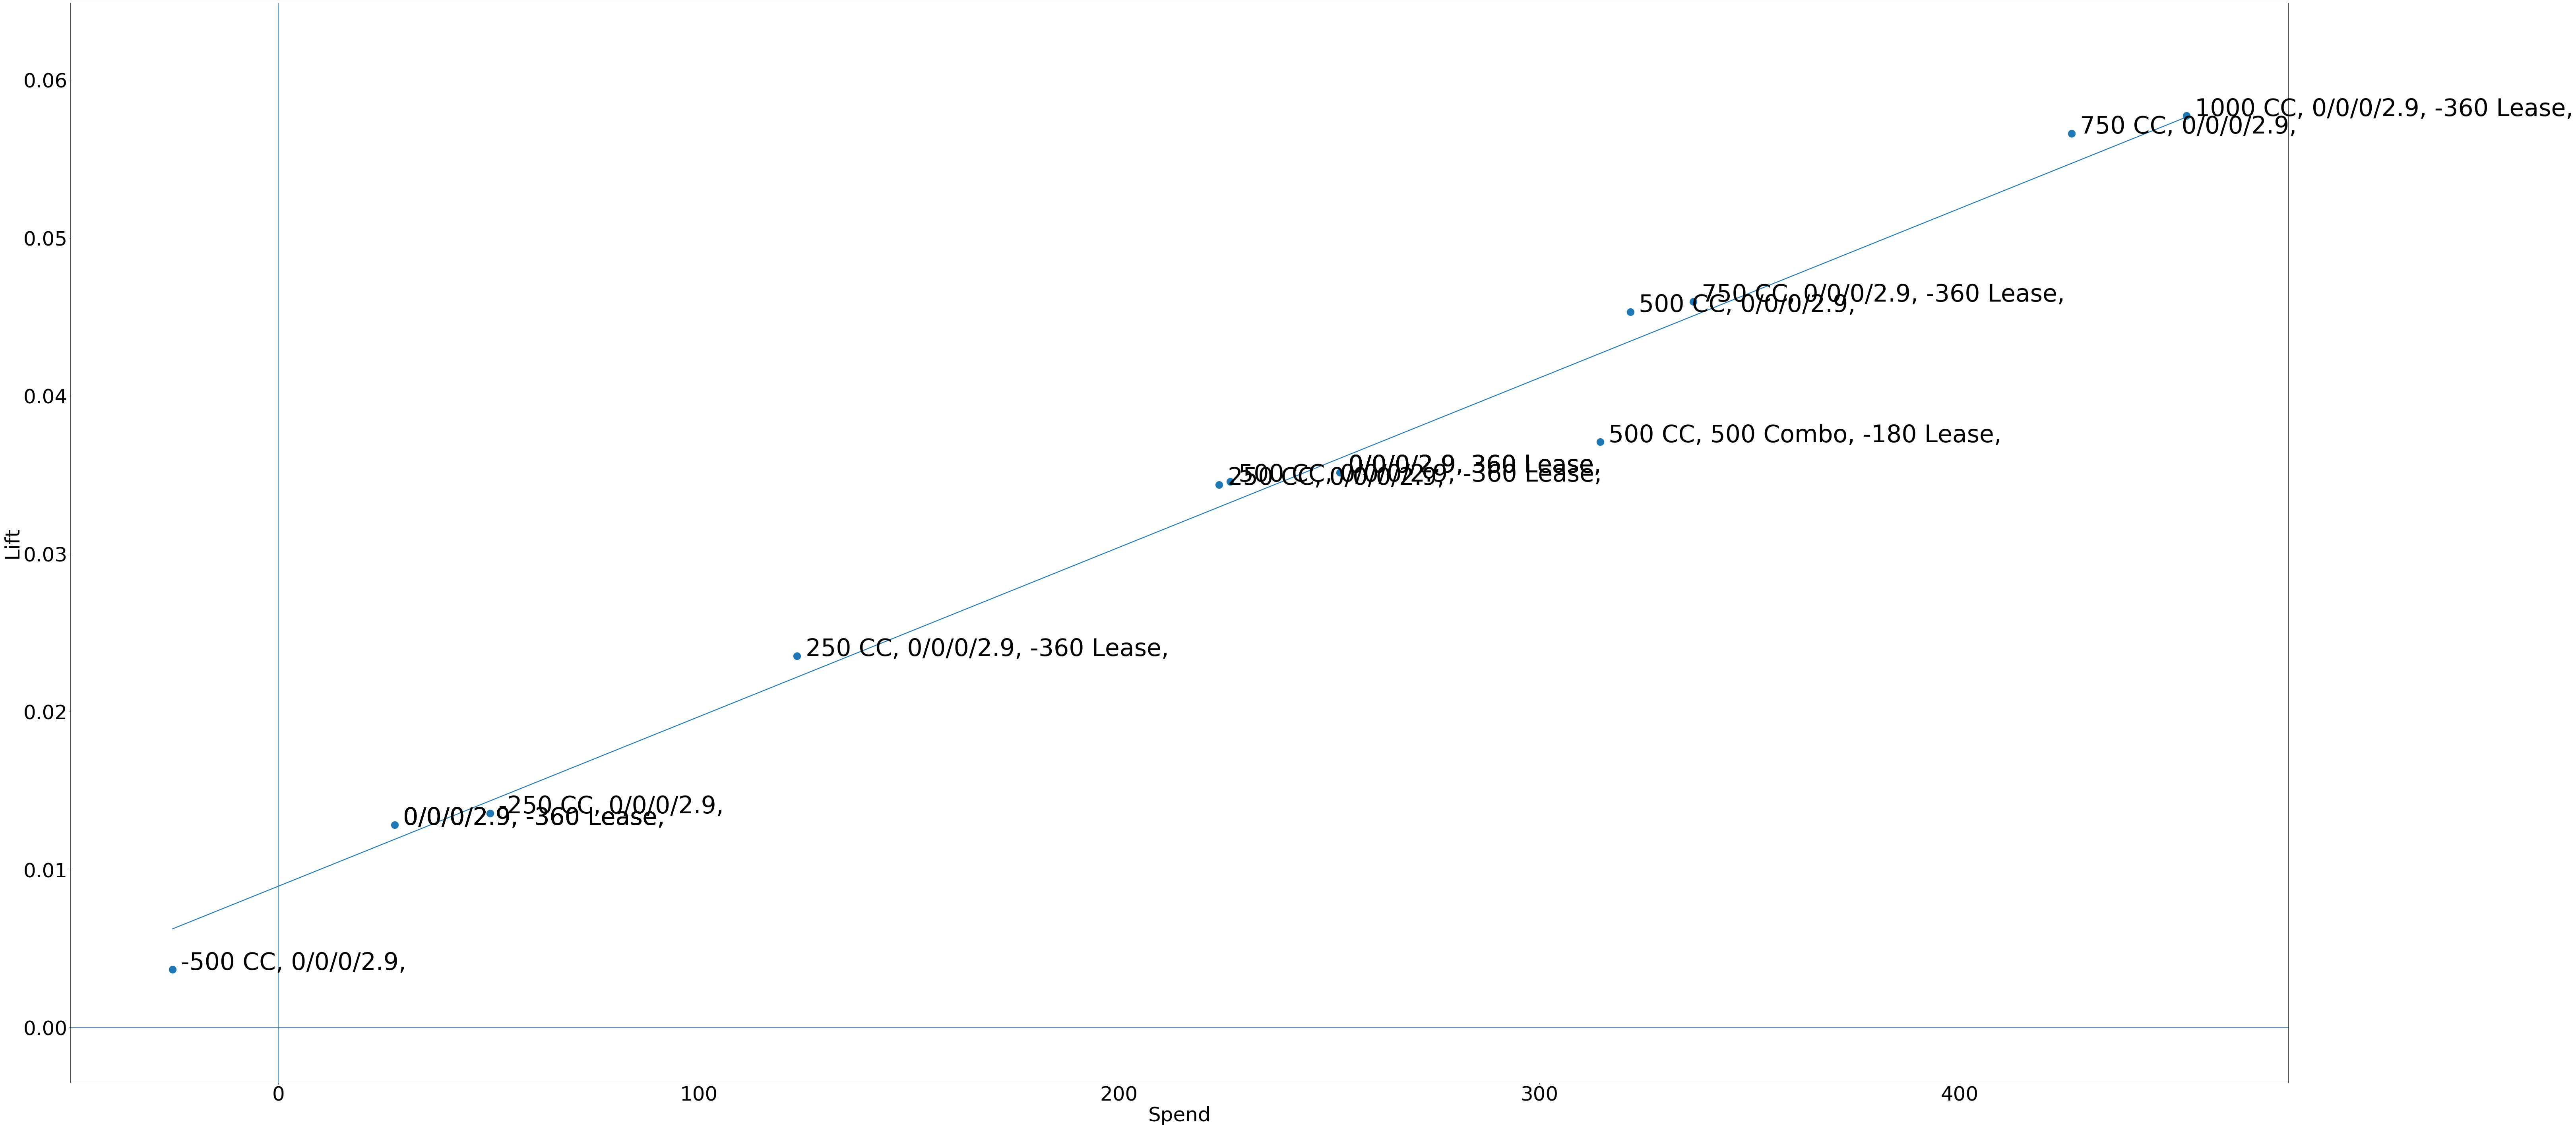

In [415]:
# Plot remaining scenarios w best fit line
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], s=400)
p2 = sns.regplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for row in range(0, scenarios.shape[0]):
    p1.text(scenarios['spend_delta'].iloc[row]+2, scenarios['lift_delta'].iloc[row], scenarios['scenarios'].iloc[row], size=60)
      
plt.show()

In [416]:
scenarios_row = list(scenarios.index.values)
DSS_scenarios = [x + 1 for x in scenarios_row]
write_to_output_tab_old_DSS(DSS_file_path, tab_name, DSS_scenarios)

In [421]:
for i in range(1,6):    
    DSS_file_path = r'C:\Users\bryant.vu\Documents\Chooser_DSS_Files\Kia\18.05.07-DSS-Template-v3.3 - MY20 Sportage 20 01 31 v1.xlsm'

    model_no = i
    spend_min = -200
    spend_max = 500

    model_list, output_tabs = DSS_extract_models_and_output_tabs_new_DSS(DSS_file_path)
    tab_name = output_tabs[model_no-1]

    scenarios = pd.DataFrame()
    df = read_from_old_DSS(DSS_file_path, tab_name, model_no)
    scenarios = df

    # Remove single lever moves (add user option in later)
    scenarios['lift/spend'] = scenarios['lift_delta'] / scenarios['spend_delta']
    scenarios = scenarios[scenarios['no_of_moves'] > 1].sort_values('spend_delta')

    # Remove APR moves with std
    reg_ex = 'std'
    reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
    scenarios = scenarios[~reg_ex_filter]

    # Create scoring system ranks

    # Elasticity as % of max elasticity
    scenarios['elasticity_score'] = scenarios['elasticity']/scenarios['elasticity'].max()/10*1.5

    # No. of moves as A B C D F grading scale
    no_of_moves_dict = {
        1: .95,
        2: .90,
        3: .85,
        4: .80,
        5: .75,
        6: .70
    }
    scenarios['no_of_moves_score'] = scenarios['no_of_moves'].map(no_of_moves_dict)

    # Spend delta as % of max delta divided by 10 
    scenarios['spend_delta_score'] = -abs(scenarios['spend_delta'])/scenarios['spend_delta'].max()

    # Total score
    scenarios['total_score'] = scenarios['elasticity_score'] + scenarios['no_of_moves_score']
    scenarios.sort_values('total_score', ascending=False, inplace=True)

    scenarios = scenarios[scenarios['spend_delta'] > spend_min]
    scenarios = scenarios[scenarios['spend_delta'] < spend_max]

    scenarios_row = list(scenarios.index.values)
    DSS_scenarios = [x + 1 for x in scenarios_row]
    write_to_output_tab_old_DSS(DSS_file_path, tab_name, DSS_scenarios)

# Mitsu Run

In [8]:
DSS_file_path = r'C:\Users\bryant.vu\Documents\Chooser_DSS_Files\dss_copy\2019.07.15 - DSS - v4.6.3 - IS, GS, RC, LC, LS, LC MY20, LS19 v2.xlsm'

In [9]:
model_no = 1
spend_min = -100
spend_max = 500

model_list, output_tabs = DSS_extract_models_and_output_tabs_new_DSS(DSS_file_path)
tab_name = output_tabs[model_no-1]

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [10]:
scenarios = pd.DataFrame()
scenarios = read_from_new_DSS(DSS_file_path, tab_name, model_no)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


###### Remove client-specific unwanted scenarios 

In [11]:
# Remove single lever moves (add user option in later)
scenarios['lift/spend'] = scenarios['lift_delta'] / scenarios['spend_delta']
scenarios = scenarios[scenarios['no_of_moves'] > 1].sort_values('spend_delta')

# Remove APR moves with std
reg_ex = 'std'
reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
scenarios = scenarios[~reg_ex_filter]

# Remove +CC and -APR moves
##reg_ex_cash = '*APR'
#reg_ex_filter = scenarios['scenarios'].str.contains(reg_ex)
CC_APR_nonzero_filter = (scenarios['cash_delta'] != 0) & (scenarios['finance_delta'] != 0)
scenarios['cash_finance_sum'] = round(scenarios['cash_delta']/50.0)*50 + round(scenarios['finance_delta']/50.0)*50
cash_finance_sum_filter = scenarios['cash_finance_sum'] == 0.0

scenarios = scenarios[~(CC_APR_nonzero_filter & cash_finance_sum_filter)]

###### Rank

In [12]:
# Create scoring system ranks

# Elasticity as % of max elasticity
scenarios['elasticity_score'] = scenarios['elasticity']/scenarios['elasticity'].max()/10*1.5

# No. of moves as A B C D F grading scale
no_of_moves_dict = {
    1: .95,
    2: .90,
    3: .85,
    4: .80,
    5: .75,
    6: .70
}
scenarios['no_of_moves_score'] = scenarios['no_of_moves'].map(no_of_moves_dict)

# Spend delta as % of max delta divided by 10 
scenarios['spend_delta_score'] = -abs(scenarios['spend_delta'])/scenarios['spend_delta'].max()

# Total score
scenarios['total_score'] = scenarios['elasticity_score'] + scenarios['no_of_moves_score']
scenarios.sort_values('total_score', ascending=False, inplace=True)

In [13]:
scenarios = scenarios[scenarios['spend_delta'] > spend_min]
scenarios = scenarios[scenarios['spend_delta'] < spend_max]

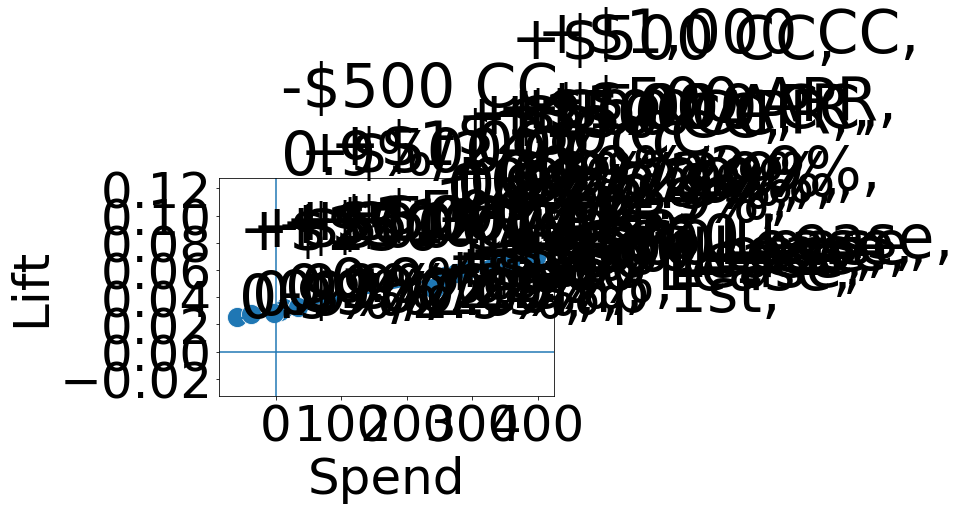

In [14]:
# Plot remaining scenarios w best fit line
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], s=400)
p2 = sns.regplot(x=scenarios['spend_delta'], y=scenarios['lift_delta'], ci=0)

ax.axhline(y=0)
ax.axvline(x=0)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlabel('Spend', fontsize=50)
plt.ylabel('Lift', fontsize=50)
plt.rcParams["figure.figsize"] = (100,50)

# Label data points
for row in range(0, scenarios.shape[0]):
    p1.text(scenarios['spend_delta'].iloc[row]+2, scenarios['lift_delta'].iloc[row], scenarios['scenarios'].iloc[row], size=60)
      
plt.show()

In [15]:
scenarios_row = list(scenarios.index.values)
DSS_scenarios = [x + 1 for x in scenarios_row]
write_to_output_tab(DSS_file_path, tab_name, DSS_scenarios)

NameError: name 'write_to_output_tab' is not defined